In [1]:
import pandas as pd
import networkx as nx

Understanding Domain Objects
====================================

ware_ops_algos represents warehouse data through **domain objects**. Understanding these is essential to use the library.

Storage Locations
-----------------

Storage locations define where articles are physically stored in your warehouse.


In [2]:
from ware_ops_algos.domain_models import Location, StorageLocations, StorageType

locations_list = [
    Location(x=1,          # Aisle number
             y=3,          # Position along the aisle
             article_id=1, # Which article is stored here
             amount=1      # Quantity available
             ),
    Location(x=1, y=8, article_id=2, amount=1),
    Location(x=2, y=5, article_id=3, amount=1),
]


# Collection of all locations in the warehouse
storage = StorageLocations(
   StorageType.DEDICATED,  # or StorageType.SCATTERED
   locations=locations_list
)
storage.build_article_location_mapping()

Articles
------

Articles represent the master data of the items stored in the warehouse.

In [3]:
from ware_ops_algos.domain_models import Article, Articles, ArticleType

articles_list = [Article(
    article_id=1,                 #  article id
    article_name="dummy_article", # article name
    weight=1,                     # article weight
    volume=1                      # article volume
),
    Article(article_id=2),
    Article(article_id=3)
]                     

articles = Articles(tpe=ArticleType.STANDARD, articles=articles_list)

Orders
------

Orders represent what customers ordered and need to be picked.

In [4]:
from ware_ops_algos.domain_models import Order, OrderPosition, OrdersDomain, OrderType

# What was ordered
order_positions = [
    OrderPosition(order_number=1, article_id=1, amount=1),
    OrderPosition(order_number=1, article_id=2, amount=1),
    OrderPosition(order_number=1, article_id=3, amount=1)
]

# Complete order with all positions
order = Order(
    order_id=1,
    order_positions=order_positions
)

# Collection of all orders
orders = OrdersDomain(
    OrderType.STANDARD,
    orders=[order]
)

Resources
---------

Resources represent pickers (humans or robots) who fulfill orders.

In [5]:
from ware_ops_algos.domain_models import Resource, PickCart, DimensionType, Resources, ResourceType

PICKER_CAPACITY = 10
pick_cart = PickCart(n_dimension=1,
                     n_boxes=1,
                     capacities=[PICKER_CAPACITY],
                     dimensions=[DimensionType.ITEMS])
resources_list = [
    Resource(id=0, speed=1.0, pick_cart=pick_cart)]

resources = Resources(ResourceType.HUMAN, resources_list)

Layout (for routing algorithms)
--------------------------------

Some routing algorithms need layout information to calculate distances.


In [6]:
from ware_ops_algos.domain_models import LayoutData, LayoutNetwork, LayoutParameters, LayoutType

depot_aisle = 1
start_location = (depot_aisle, -1)
end_location = (depot_aisle - 1, -1)
start_conn = (depot_aisle, 0)
end_conn = (depot_aisle, 0)
closest_node_to_start = (depot_aisle, 0)

layout_params = LayoutParameters(
                 n_aisles=10,
                 n_pick_locations=10,
                 dist_aisle=1,
                 dist_pick_locations=1,
                 dist_top_to_pick_location=1,
                 dist_bottom_to_pick_location=1,
                 dist_start=1,
                 dist_end=1,
                 start_location=start_location,
                 end_location=end_location,
                 n_blocks=1,
                 start_connection_point=start_conn,
                 end_connection_point=end_conn)


We can now use the information defined in LayoutParams to generate a simple graph of the warehouse

In [7]:
from ware_ops_algos.generators import ShelfStorageGraphGenerator
            
graph_gen = ShelfStorageGraphGenerator(
    n_aisles=layout_params.n_aisles,
    n_pick_locations=layout_params.n_pick_locations,
    dist_aisle=layout_params.dist_aisle,
    dist_pick_locations=layout_params.dist_pick_locations,
    dist_aisle_location=layout_params.dist_top_to_pick_location,
    dist_start=layout_params.dist_start,
    dist_end=layout_params.dist_end,
    start_location=layout_params.start_location,
    end_location=layout_params.end_location
)

graph_gen.populate_graph()

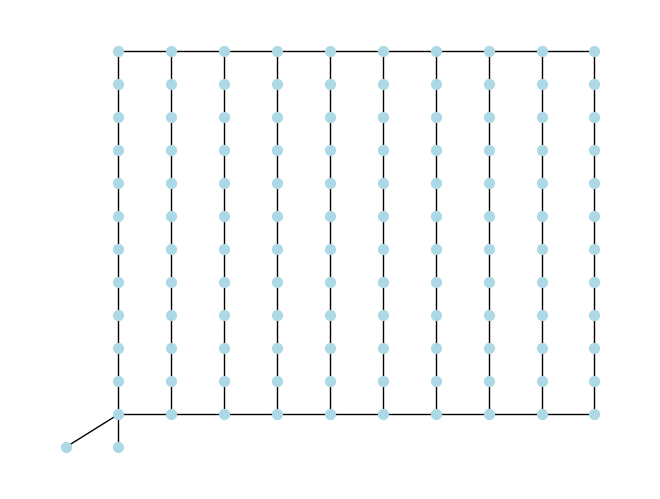

In [8]:
from ware_ops_algos.utils.visualization import render_graph

render_graph(graph_gen.G)

In [9]:
from scipy.sparse.csgraph import floyd_warshall

nodes = list(graph_gen.G.nodes())
A = nx.to_scipy_sparse_array(graph_gen.G, nodelist=nodes, weight='weight', dtype=float)
dist_mat, predecessors = floyd_warshall(A, directed=False, return_predecessors=True)
dima = pd.DataFrame(dist_mat, index=nodes, columns=nodes)
        
layout_network = LayoutNetwork(
    graph=graph_gen.G,
    start_node=start_location,
    end_node=end_location,
    closest_node_to_start=closest_node_to_start,
    min_aisle_position=0,
    max_aisle_position=layout_params.n_pick_locations + 1,
    distance_matrix=dima,
    predecessor_matrix=predecessors
)
layout = LayoutData(tpe=LayoutType.CONVENTIONAL, layout_network=layout_network, graph_data=layout_params)

# WarehouseInfo

The WarehouseInfo domain object can be used to pass additional information to the domain instance that is not directly associated with any of the other domain objects. For now we only specify that it is an offline problem.

In [10]:
from ware_ops_algos.domain_models import WarehouseInfo, WarehouseInfoType

warehouse_info = WarehouseInfo(tpe=WarehouseInfoType.OFFLINE)

# Warehouse Domain

Individual domain objects can be grouped in a WarehouseDomain object. We define it as an order batching and picker routing problem (OBRP)

In [11]:
from ware_ops_algos.domain_models import BaseWarehouseDomain

domain_instance = BaseWarehouseDomain(
    problem_class="OBRP", 
    objective="Distance", 
    layout=layout, 
    articles=articles, 
    orders=orders, 
    resources=resources, 
    storage=storage,
    warehouse_info=warehouse_info
)

# Algorithms

ware_ops_algos implements a number of algorithms for e.g. batching, routing, scheduling etc. Each algorithm is described in the form of a model card that specifies the algorithm requirements.

In [12]:
from ware_ops_algos.utils.general_functions import load_model_cards

all_algorithms = load_model_cards("../../../src/ware_ops_algos/algorithms/opt_model_cards")

# Algorithm Filter

Based on the defined warehouse domain and the algorithm cards we can obtain the applicable algorithms for the domain.   

In [13]:
from ware_ops_algos.domain_models.taxonomy import SUBPROBLEMS
from ware_ops_algos.algorithms.algorithm_filter import AlgorithmFilter

filter = AlgorithmFilter(
    subproblems=SUBPROBLEMS,
)

subset = filter.filter(algorithms=all_algorithms, instance=domain_instance, verbose=True)

Problem type filtering for 'OBRP':
  Accepted types: {'routing', 'batching', 'item_assignment', 'order_selection', 'OBRP'}
  Result: 32/38 algorithms match

  Checking: ClarkAndWrightNN
    ✓ Algorithm is feasible

  Checking: ClarkAndWrightRR
    ✓ Algorithm is feasible

  Checking: ClarkAndWrightSShape
    ✓ Algorithm is feasible

  Checking: ClosestDepotMaxSharedArticlesSeedBatching
    ✓ Algorithm is feasible

  Checking: ClosestDepotMinDistanceSeedBatching
    ✓ Algorithm is feasible

  Checking: CombinedBatchingRoutingAssigning
    ✓ Algorithm is feasible

  Checking: DueDate
    ✗ orders: constraint violated - due_date=False does not satisfy {'equals': True}

  Checking: FiFo
    ✗ orders: constraint violated - order_date=False does not satisfy {'equals': True}

  Checking: GreedyIA
    ✓ Algorithm is feasible

  Checking: NNItemAssignment
    ✗ storage: type 'dedicated' not in required types ['scattered']

  Checking: LargestGap
    ✓ Algorithm is feasible

  Checking: LSBatchi

In [14]:
subset

[name=ClarkAndWrightNN problem=batching>,
 name=ClarkAndWrightRR problem=batching>,
 name=ClarkAndWrightSShape problem=batching>,
 name=ClosestDepotMaxSharedArticlesSeedBatching problem=batching>,
 name=ClosestDepotMinDistanceSeedBatching problem=batching>,
 name=CombinedBatchingRoutingAssigning problem=batching>,
 name=GreedyIA problem=item_assignment>,
 name=LargestGap problem=routing>,
 name=LSBatchingNNRand problem=batching>,
 name=LSBatchingRR problem=batching>,
 name=Midpoint problem=routing>,
 name=NearestNeighbourhood problem=routing>,
 name=DummyOS problem=order_selection>,
 name=PLRouting problem=routing>,
 name=Random problem=batching>,
 name=RandomMinDistanceSeedBatching problem=batching>,
 name=Return problem=routing>,
 name=RatliffRosenthal problem=routing>,
 name=SShape problem=routing>,
 name=ExactSolving problem=routing>]

Complete Example
================

2.7099973522126675e-05


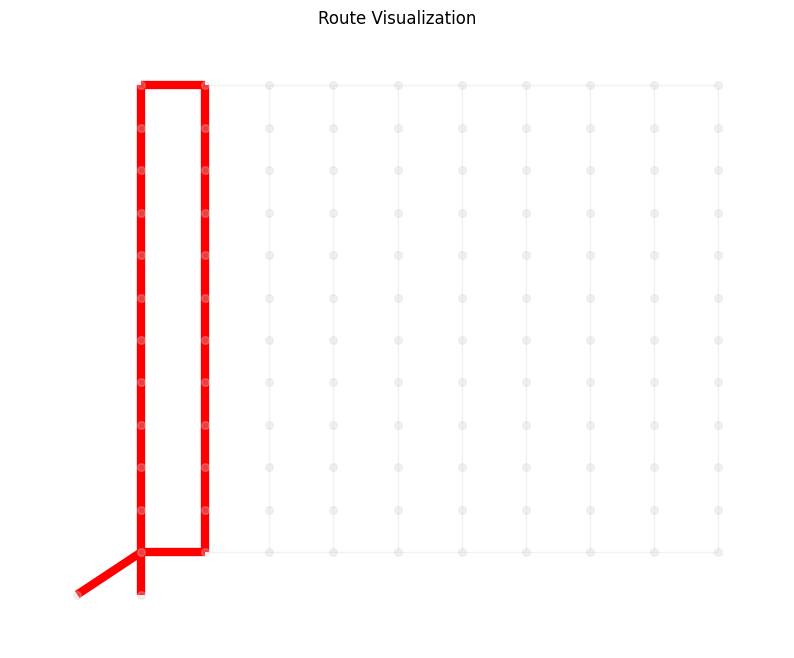

26.0


In [15]:
from ware_ops_algos.utils.visualization import plot_route
from ware_ops_algos.algorithms import ExactTSPRoutingDistance, NearestNeighbourhoodRouting, SShapeRouting, \
    OrderNrFifoBatching, GreedyItemAssignment

orders = domain_instance.orders
layout = domain_instance.layout
resources = domain_instance.resources
articles = domain_instance.articles
storage_locations = domain_instance.storage

layout_network = layout.layout_network
graph_data = layout.graph_data
graph = layout_network.graph
graph_params = layout.graph_data
dima = layout_network.distance_matrix

selector = GreedyItemAssignment(storage_locations)
ia_sol = selector.solve(orders.orders)
orders.orders = ia_sol.resolved_orders

batcher = OrderNrFifoBatching(
            pick_cart=resources.resources[0].pick_cart,
            articles=articles
        )

batching_sol = batcher.solve(orders.orders)

print(batching_sol.execution_time)

# Build pick list from batches
batches = batching_sol.batches
pick_lists = []
for batch in batches:
    pick_list = []
    for order in batch.orders:
        for pos in order.pick_positions:
            pick_list.append(pos)
    pick_lists.append(pick_list)

ss_router = SShapeRouting(
            start_node=layout_network.start_node,
            end_node=layout_network.end_node,
            closest_node_to_start=layout_network.closest_node_to_start,
            min_aisle_position=layout_network.min_aisle_position,
            max_aisle_position=layout_network.max_aisle_position,
            distance_matrix=layout_network.distance_matrix,
            predecessor_matrix=layout_network.predecessor_matrix,
            picker=resources.resources,
            gen_tour=True,
            gen_item_sequence=True,
            node_list=layout_network.node_list,
            node_to_idx={node: idx for idx, node in enumerate(list(layout_network.graph.nodes))},
            idx_to_node={idx: node for idx, node in enumerate(list(layout_network.graph.nodes))}
        )

total_dist = 0
for pl in pick_lists:
    sol = ss_router.solve(pl)
    total_dist += sol.route.distance
    plot_route(graph, sol.route.route)
    ss_router.reset_parameters()
print(total_dist)